# Latent Dirichlet Allocation

## Packages

In [15]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Formatting
import ast

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# LDA
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models

from gensim.models.coherencemodel import CoherenceModel

In [2]:
# Load NLTK tools
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /Users/cindy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [3]:
# Load data
data_folder = '../data/'
df = pd.read_csv(data_folder + 'scraped_data_no_names.csv')
transcript_df = pd.DataFrame(df['transcript'])

## Text Processing: NLP pipeline

In [4]:
# Tokenization
transcript_df['tokenized'] = transcript_df['transcript'].apply(tokenizer.tokenize)

In [5]:
# Removing stopwords and Casefolding
transcript_df['no_stopwords'] = transcript_df['tokenized'].apply(
    lambda l: [s.casefold() for s in l if s.casefold() not in stop_words and s not in stop_words])

In [6]:
# Lemmatization
transcript_df['lemmatized'] = transcript_df['no_stopwords'].apply(
    lambda l: [lemmatizer.lemmatize(s) for s in l])

In [7]:
transcript_df.head()

,transcript,tokenized,no_stopwords,lemmatized
0,": This is Wednesday, March 20. : March 20. ...","[This, is, Wednesday, March, 20, March, 20, 20...","[wednesday, march, 20, march, 20, 2019, cindy,...","[wednesday, march, 20, march, 20, 2019, cindy,..."
1,"Okay. It is January 15th, 2019, and we are in ...","[Okay, It, is, January, 15th, 2019, and, we, a...","[okay, january, 15th, 2019, lynnwood, washingt...","[okay, january, 15th, 2019, lynnwood, washingt..."
2,"Our second interview is with Richard Eymann, S...","[Our, second, interview, is, with, Richard, Ey...","[second, interview, richard, eymann, spokane, ...","[second, interview, richard, eymann, spokane, ..."
3,"It’s April 29, 2019. Our first interview is wi...","[It, s, April, 29, 2019, Our, first, interview...","[april, 29, 2019, first, interview, f, robert,...","[april, 29, 2019, first, interview, f, robert,..."
4,"How would you describe your mother, grandmothe...","[How, would, you, describe, your, mother, gran...","[would, describe, mother, grandmother, mary, e...","[would, describe, mother, grandmother, mary, e..."


---

## Bag of Words (BoW)

In [8]:
# Create a gensim dictionary
dictionary = Dictionary(transcript_df['lemmatized'])

In [9]:
# Filter out tokens that appear in less than 30 documents and more than 50% documents, keep only the first 100000 most frequent tokens
dictionary.filter_extremes(no_below=30, no_above=0.5, keep_n=100000)

In [10]:
# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text) for text in transcript_df['lemmatized']]

---

## Topic Modelling: LDA

### Coherence score to find the optimal number of topics

In [23]:
# Define range of number of topics
num_topics_range = range(10, 101, 10)

# Compute coherence scores for different number of topics
coherence_scores = []
for num_topics in num_topics_range:
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=12345
    )
    coherence_model = CoherenceModel(model=lda_model, texts=transcript_df['lemmatized'], corpus=corpus, coherence='c_v', topn=20)
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"Number of topics: {num_topics}. Coherence score: {coherence_score}")

Number of topics: 10. Coherence score: 0.2279469057636599
Number of topics: 20. Coherence score: 0.23413723305483547
Number of topics: 30. Coherence score: 0.233098878658661
Number of topics: 40. Coherence score: 0.23721941048235987
Number of topics: 50. Coherence score: 0.23597116289469924
Number of topics: 60. Coherence score: 0.24522735762758613
Number of topics: 70. Coherence score: 0.2476052292351906
Number of topics: 80. Coherence score: 0.24510492918686203
Number of topics: 90. Coherence score: 0.2453715231565284


/Users/cindy/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cindy/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/cindy/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/cindy/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/cindy/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutil

Number of topics: 100. Coherence score: 0.2487378279165097


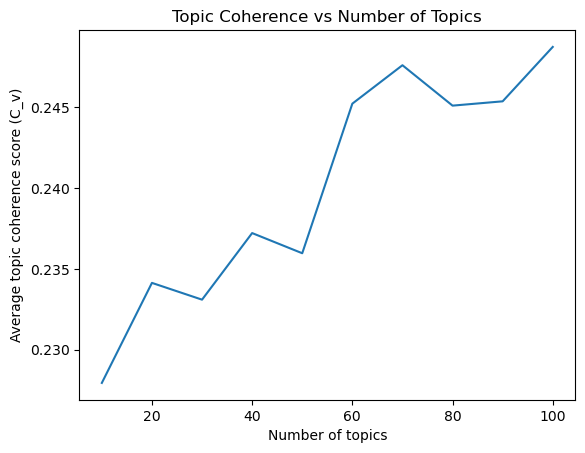

In [24]:
sns.lineplot(x=num_topics_range, y=coherence_scores)
plt.xlabel("Number of topics")
plt.ylabel("Average topic coherence score (C_v)")
plt.title("Topic Coherence vs Number of Topics")
plt.show()

### With the optimal number of topics

In [25]:
# Train an LDA model on the corpus with the optimal number of topics
num_topics = num_topics_range[np.array(coherence_scores).argmax()]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

In [26]:
# Visualize the results using pyLDAvis
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis_data, f'../results/lda_{num_topics}.html')

/Users/cindy/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


---